In [79]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy import stats

import warnings;
warnings.filterwarnings('ignore');

Now, we load all of the csv files into a master list of matches. 

In [3]:
def process_csvs():
    files = os.listdir(r"/Users/suchirjoshi/Desktop/Cricket Analytics/ODI folder/")
    folder = files[0:len(files)-1]
    csvs = []
    for file in folder:
        if file.endswith('.csv'):
            cleaned_file = pd.read_csv((r"/Users/suchirjoshi/Desktop/Cricket Analytics/ODI folder/" + 
                        file), names=(["type", "innings", "ball_notation", "team_batting", 
                                                      "batsman_on_strike", "batsmen_off_strike", "bowler",
                                                       "runs_scored", "extras_scored", "type_of_dismissal", 
                                                       "person_of_dismissal"]), engine='python')
            match_date_row = cleaned_file[cleaned_file["innings"] == "date"]
        
        
            csvs.append(pd.concat([match_date_row, cleaned_file.dropna(thresh=4)]))
        
    return csvs

list_of_matches = process_csvs()

An example of a match, with the first row detailing the date and the other rows containing ball-by-ball data. The date row is included so that we can analyze data by year. 

In [44]:
list_of_matches[5].head()

,type,innings,ball_notation,team_batting,batsman_on_strike,batsmen_off_strike,bowler,runs_scored,extras_scored,type_of_dismissal,person_of_dismissal
5,info,date,2014/02/23,None,None,None,None,NaN,NaN,None,None
17,ball,1,0.1,Ireland,WTS Porterfield,PR Stirling,JO Holder,0.0,0.0,NaN,NaN
18,ball,1,0.2,Ireland,WTS Porterfield,PR Stirling,JO Holder,0.0,0.0,NaN,NaN
19,ball,1,0.3,Ireland,WTS Porterfield,PR Stirling,JO Holder,0.0,0.0,NaN,NaN
20,ball,1,0.4,Ireland,WTS Porterfield,PR Stirling,JO Holder,0.0,0.0,NaN,NaN


Now, we scrape Cricinfo data to get a list of all the fast bowlers and spin bowlers who have bowled in ODI cricket. The following code generates a list, spinners_lst, of all spinners in ODI history. 

In [7]:
import requests
from bs4 import BeautifulSoup

page = 1
spinners_lst = []
while page <= 5:
    url = ("http://stats.espncricinfo.com/ci/engine/stats/index.html?bowling_pacespin=2;" + 
           "class=2;filter=advanced;orderby=wickets;page=" + str(page) + ";size=200;template=results;type=bowling")
    link = requests.get(url)
    souped_link = BeautifulSoup(link.content, "html.parser")
    page_lst = souped_link.find_all("tr", class_= "data1")
    for td in page_lst:
        spinners_lst.append(td.find("a").get_text())
    page += 1

This code generates a list, pacers_lst, of all fast bowlers. 

In [8]:
page = 1
pacers_lst = []
while page <= 7:
    url = ("http://stats.espncricinfo.com/ci/engine/stats/index.html?bowling_pacespin=1;" + 
           "class=2;filter=advanced;orderby=wickets;page=" + str(page) + ";size=200;template=results;type=bowling")
    link = requests.get(url)
    souped_link = BeautifulSoup(link.content, "html.parser")
    page_lst = souped_link.find_all("tr", class_= "data1")
    for td in page_lst:
        pacers_lst.append(td.find("a").get_text())
    page += 1

As we can see, there have been 901 spinners and 1267 fast bowlers in ODI history for us to analyze. 

In [9]:
print(len(spinners_lst))
print(len(pacers_lst))

901
1267


This function will conduct analysis on a given ten over interval of each match, and return the following: total score, and runs conceded, balls bowled, and wickets taken for both fast bowlers and spinners in that interval, as well as the eventual innings score. Start and end correspond to the beginning and end of the interval, respectively. 

There are 3 possible cases, and if a particular innings fulfills any of these cases, it is included in our analysis: 

1. (For second innings only) The second innings score is more than the first innings score, i.e. a successful chase. 
2. All ten wickets have fallen in the innings. 
3. The last ball's ball notation is 49., i.e. the innings lasted its full duration. 

These cases exclude the occassions where the match has been rained out or called incomplete for another reason. 

In [14]:
def data_generator_by_interval(matches, start, end):
    df = pd.DataFrame(np.random.randn(1, 10), columns=["Year", "Score During Overs", "Pacer Runs During Overs", "Spinner Runs During Overs", "Pacer Balls During Overs", "Spinner Balls During Overs", "Pacer Wickets During Overs", "Spinner Wickets During Overs", "Wickets During Overs", "Total Innings Score"])
    result = df
    for match in matches:
        date_str = match.iloc[0, 2]
        year_str = date_str[0:date_str.find("/")]
        year_float = float(year_str)
        
        match = match.iloc[1:, :]
        try:
            match.ball_notation = [float(ball) for ball in match.ball_notation]
        except:
            continue
        
        first_innings = match[match.innings == "1"]
        
        first_condition_1 = first_innings["ball_notation"] > start
        first_condition_2 = first_innings["ball_notation"] < end
        first_criteria = first_condition_1 & first_condition_2
        first_specified_overs = first_innings[first_criteria]
        
        first_innings_specified_over_score = first_specified_overs.iloc[:, 7].sum() + first_specified_overs.iloc[:, 8].sum()
        first_specified_overs_wickets = len(first_specified_overs.dropna())
        first_innings_total_score = first_innings.iloc[:, 7].sum() + first_innings.iloc[:, 8].sum()
        
        second_innings = match[match.innings == "2"]
        
        second_condition_1 = second_innings["ball_notation"] > start
        second_condition_2 = second_innings["ball_notation"] < end
        second_criteria = second_condition_1 & second_condition_2
        second_specified_overs = second_innings[second_criteria]
        
        second_innings_specified_over_score = second_specified_overs.iloc[:, 7].sum() + second_specified_overs.iloc[:, 8].sum()
        second_specified_overs_wickets = len(second_specified_overs.dropna())
        second_innings_total_score = second_innings.iloc[:, 7].sum() + second_innings.iloc[:, 8].sum()
        
        first_innings_wickets_total = len(first_innings.dropna())
        second_innings_wickets_total = len(second_innings.dropna())
        
        first_specified_overs_spinners = first_specified_overs[first_specified_overs["bowler"].isin(spinners_lst)]
        first_specified_overs_pacers = first_specified_overs[first_specified_overs["bowler"].isin(pacers_lst)]
        
        second_specified_overs_spinners = second_specified_overs[second_specified_overs["bowler"].isin(spinners_lst)]
        second_specified_overs_pacers = second_specified_overs[second_specified_overs["bowler"].isin(pacers_lst)]
        
        
        first_specified_overs_spinner_runs = first_specified_overs_spinners.iloc[:, 7].sum() + first_specified_overs_spinners.iloc[:, 8].sum()
        first_specified_overs_pacer_runs = first_specified_overs_pacers.iloc[:, 7].sum() + first_specified_overs_pacers.iloc[:, 8].sum()
        
        second_specified_overs_spinner_runs = second_specified_overs_spinners.iloc[:, 7].sum() + second_specified_overs_spinners.iloc[:, 8].sum()
        second_specified_overs_pacer_runs = second_specified_overs_pacers.iloc[:, 7].sum() + second_specified_overs_pacers.iloc[:, 8].sum()
        
        
        first_specified_overs_spinner_wickets = len(first_specified_overs_spinners.dropna())
        first_specified_overs_pacer_wickets = len(first_specified_overs_pacers.dropna())
        
        second_specified_overs_spinner_wickets = len(second_specified_overs_spinners.dropna())
        second_specified_overs_pacer_wickets = len(second_specified_overs_pacers.dropna())

        
        lst1 = first_innings.ball_notation
        if len(lst1) != 0 and (first_innings_wickets_total == 10.0 or round(lst1.iloc[len(lst1)-1]) == 50.0):
                
            s1 = pd.DataFrame({"Year" : [year_float],
                               "Score During Overs" : [first_innings_specified_over_score],
                               "Pacer Runs During Overs": [first_specified_overs_pacer_runs],
                               "Spinner Runs During Overs": [first_specified_overs_spinner_runs], 
                               "Pacer Balls During Overs": [len(first_specified_overs_pacers)],
                               "Spinner Balls During Overs": [len(first_specified_overs_spinners)],
                               "Pacer Wickets During Overs": [first_specified_overs_pacer_wickets],
                               "Spinner Wickets During Overs": [first_specified_overs_spinner_wickets], 
                          "Wickets During Overs" : [first_specified_overs_wickets], 
                          "Total Innings Score" : [first_innings_total_score]})
        
            result = result.append(s1, ignore_index=True)

            
        lst2 = second_innings.ball_notation
        if len(lst2) != 0 and (second_innings_wickets_total == 10 or second_innings_total_score >= first_innings_total_score or round(lst2.iloc[len(lst2)-1]) == 50.0): 
                
            s2 = pd.DataFrame({"Year" : [year_float],
                               "Score During Overs" : [second_innings_specified_over_score],
                               "Pacer Runs During Overs": [second_specified_overs_pacer_runs],
                               "Spinner Runs During Overs": [second_specified_overs_spinner_runs], 
                               "Pacer Balls During Overs": [len(second_specified_overs_pacers)],
                               "Spinner Balls During Overs": [len(second_specified_overs_spinners)],
                               "Pacer Wickets During Overs": [second_specified_overs_pacer_wickets],
                               "Spinner Wickets During Overs": [second_specified_overs_spinner_wickets],
                          "Wickets During Overs" : [second_specified_overs_wickets], 
                          "Total Innings Score" : [second_innings_total_score]})
        
            result = result.append(s2, ignore_index=True)
    
    return result.iloc[1:, :]

The following dataframes contain data for each possible 10 over interval. 

In [17]:
first_ten_overs = data_generator_by_interval(list_of_matches, 0, 10)

In [18]:
second_ten_overs = data_generator_by_interval(list_of_matches, 10, 20)

In [19]:
third_ten_overs = data_generator_by_interval(list_of_matches, 20, 30)

In [20]:
fourth_ten_overs = data_generator_by_interval(list_of_matches, 30, 40)

In [21]:
fifth_ten_overs = data_generator_by_interval(list_of_matches, 40, 50)

This is what a sample dataframe looks like. This is the data for overs 0-10. 

In [23]:
fifth_ten_overs.head()

,Year,Score During Overs,Pacer Runs During Overs,Spinner Runs During Overs,Pacer Balls During Overs,Spinner Balls During Overs,Pacer Wickets During Overs,Spinner Wickets During Overs,Wickets During Overs,Total Innings Score
1,2007.0,63.0,53.0,10.0,49.0,12.0,4.0,0.0,4.0,269.0
2,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0
3,2014.0,18.0,12.0,0.0,20.0,0.0,2.0,0.0,4.0,157.0
4,2014.0,34.0,22.0,12.0,30.0,25.0,0.0,0.0,0.0,158.0
5,2012.0,57.0,50.0,7.0,50.0,12.0,2.0,1.0,3.0,190.0


Now, we calculate the economy, strike rate, and proportion of deliveries bowled for each type of bowler, given a certain interval dataframe. 

In [29]:
def interval_data_generator(interval):

    pacer_economy = (interval["Pacer Runs During Overs"].sum() / interval["Pacer Balls During Overs"].sum()) * 6
    spinner_economy = (interval["Spinner Runs During Overs"].sum() / interval["Spinner Balls During Overs"].sum()) * 6
    pacer_strike_rate = 1 / (interval["Pacer Wickets During Overs"].sum() / interval["Pacer Balls During Overs"].sum())
    spinner_strike_rate = 1 / (interval["Spinner Wickets During Overs"].sum() / interval["Spinner Balls During Overs"].sum())
    pacer_proportion_ratio = (interval["Pacer Balls During Overs"].sum() / (interval["Pacer Balls During Overs"].sum() + interval["Spinner Balls During Overs"].sum())) * 100
    spinner_proportion_ratio = 100 - pacer_proportion_ratio
    
    return [pacer_economy, spinner_economy, pacer_strike_rate, spinner_strike_rate, pacer_proportion_ratio, spinner_proportion_ratio]

Here, we calculate the data for each interval, and construct a dataframe out of it. 

In [32]:
interval_data = {"0-10" : interval_data_generator(first_ten_overs), 
                "10-20" : interval_data_generator(second_ten_overs), 
                "20-30" : interval_data_generator(third_ten_overs), 
                "30-40" : interval_data_generator(fourth_ten_overs), 
                "40-50" : interval_data_generator(fifth_ten_overs)}

In [42]:
interval_dataframe = pd.DataFrame(data=interval_data).T
interval_dataframe.columns = ["Pacer Economy", "Spinner Economy", "Pacer Strike Rate", 
                              "Spinner Strike Rate", "Pacer Proportion", "Spinner Proportion"]

In [43]:
interval_dataframe

,Pacer Economy,Spinner Economy,Pacer Strike Rate,Spinner Strike Rate,Pacer Proportion,Spinner Proportion
0-10,4.547737,4.388857,45.749762,42.463415,93.231343,6.768657
10-20,4.522922,4.297413,46.654437,53.128518,62.427937,37.572063
20-30,4.781754,4.602910,45.919317,51.201426,40.719032,59.280968
30-40,5.415710,4.866632,35.272727,38.881797,50.932307,49.067693
40-50,7.308770,6.180811,17.141356,22.138930,70.666522,29.333478


What kind of insights can we draw from this dataframe? Let us first compare economy, strike rate, and proportion of balls bowled for each interval. 

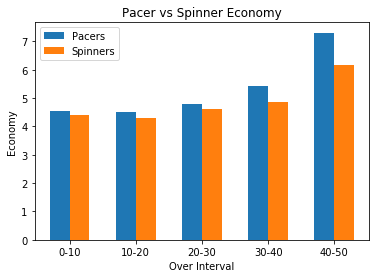

In [61]:
N = 5
pacers = interval_dataframe["Pacer Economy"]
spinners = interval_dataframe["Spinner Economy"]

ind = np.arange(N) 
width = 0.30       
plt.bar(ind, pacers, width, label='Pacers')
plt.bar(ind + width, spinners, width,
    label='Spinners')

plt.ylabel("Economy")
plt.title("Pacer vs Spinner Economy")
plt.xlabel("Over Interval")

plt.xticks(ind + width / 2, ("0-10", "10-20", "20-30", "30-40", "40-50"))
plt.legend(loc='best')
plt.show()

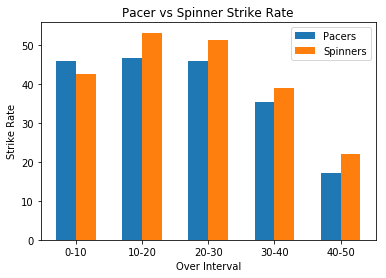

In [62]:
N = 5
pacers = interval_dataframe["Pacer Strike Rate"]
spinners = interval_dataframe["Spinner Strike Rate"]

ind = np.arange(N) 
width = 0.30       
plt.bar(ind, pacers, width, label='Pacers')
plt.bar(ind + width, spinners, width,
    label='Spinners')

plt.ylabel("Strike Rate")
plt.title("Pacer vs Spinner Strike Rate")
plt.xlabel("Over Interval")

plt.xticks(ind + width / 2, ("0-10", "10-20", "20-30", "30-40", "40-50"))
plt.legend(loc='best')
plt.show()

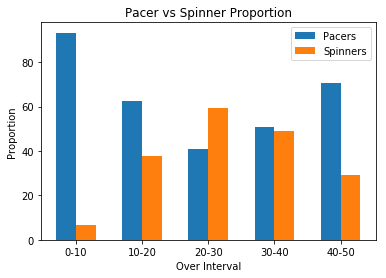

In [60]:
N = 5
pacers = interval_dataframe["Pacer Proportion"]
spinners = interval_dataframe["Spinner Proportion"]

ind = np.arange(N) 
width = 0.30       
plt.bar(ind, pacers, width, label='Pacers')
plt.bar(ind + width, spinners, width,
    label='Spinners')

plt.ylabel("Proportion")
plt.title("Pacer vs Spinner Proportion")
plt.xlabel("Over Interval")

plt.xticks(ind + width / 2, ("0-10", "10-20", "20-30", "30-40", "40-50"))
plt.legend(loc='best')
plt.show()

We see that pacers are used more often than spinners except the 20-30th over interval, but spinners are consistently more economical. Furthermore, they take wickets more often than pacers in the PowerPlay overs, perhaps dispelling the myth that fast bowlers are the more aggressive choice early on.

Now, let us explore some interesting strategy implications. As a batting team, how can we best increase our total innings score?

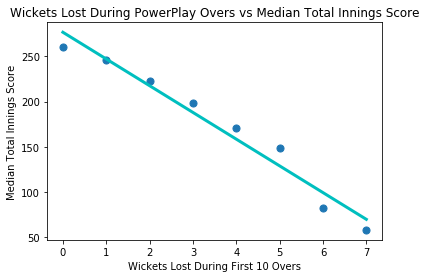

In [76]:
median_first_ten_overs = first_ten_overs.groupby("Wickets During Overs", as_index=False).median()
plt.xlabel("Wickets Lost During First 10 Overs")
plt.ylabel("Median Total Innings Score")
median_x = median_first_ten_overs["Wickets During Overs"]
median_y = median_first_ten_overs["Total Innings Score"]
plt.scatter(median_x, median_y, label="Wickets After 10 Overs vs Median Score", s=50)
plt.title("Wickets Lost During PowerPlay Overs vs Median Total Innings Score")
plt.plot(np.unique(median_x), np.poly1d(np.polyfit(median_x, median_y, 1))(np.unique(median_x)), c="c", linewidth=3)
plt.show()

In [80]:
stats.linregress(median_x, median_y)

LinregressResult(slope=-29.583333333333332, intercept=276.79166666666663, rvalue=-0.98177027045447551, pvalue=1.4939080415698161e-05, stderr=2.3381823198473133)

There's a clear negative correlation between wickets lost in the PowerPlay and total innings score! Our line of best fit has an r-value of -0.98, which indicates that it is a very strong relationship indeed. Furthermore, the line has a slope of -29.5833. This means that for every wicket that a batting team loses in the PowerPlay, the expected score drops by 30!

In [93]:
median_spinners_balls_bowled_first_ten = first_ten_overs.groupby("Spinner Balls During Overs", as_index=False).median()

In [106]:
starts = [0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0, 48.0, 54.0]
medians = []

for start in starts:
    median_table = first_ten_overs.loc[(first_ten_overs["Spinner Balls During Overs"] >= start) & 
                                       (first_ten_overs["Spinner Balls During Overs"] <= (start + 6.0))]
    median_score = np.median(median_table["Total Innings Score"])
    medians.append(median_score)
    
medians

[237.0, 236.0, 235.0, 242.5, 211.5, 217.0, 189.0, 178.0, 188.0, 208.0]

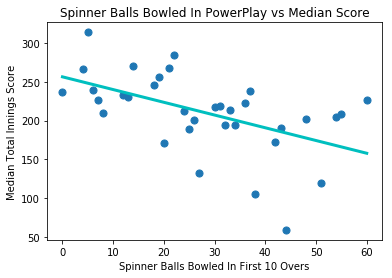

In [108]:
median_spinner_x = median_spinners_balls_bowled_first_ten["Spinner Balls During Overs"]
median_spinner_y = median_spinners_balls_bowled_first_ten["Total Innings Score"]
#plt.yticks(np.arange(150, 350, 50))
plt.xlabel("Spinner Balls Bowled In First 10 Overs")
plt.ylabel("Median Total Innings Score")
plt.scatter(median_spinner_x, median_spinner_y, label="Spinner Balls Bowled In PowerPlay vs Median Score", s=50)
plt.title("Spinner Balls Bowled In PowerPlay vs Median Score")
plt.plot(np.unique(median_spinner_x), np.poly1d(np.polyfit(median_spinner_x, median_spinner_y, 1))(np.unique(median_spinner_x)), c="c", linewidth=3)
plt.show()

In [109]:
stats.linregress(median_spinner_x, median_spinner_y)

LinregressResult(slope=-1.6431770468859341, intercept=256.48362491252624, rvalue=-0.51750650103805673, pvalue=0.001722085281816801, stderr=0.48029113855122707)

The correlation is definitely less strong here, with an r-value of -0.517, but that's to be expected as there are 60 possibilities (1-60) of the number of balls that spinners can bowl in the powerplay, and therefore it's very high variance. However, there's still a clearly strong trend: the more balls spinners bowl in the PowerPlay, the lower the total innings score tends to be. This is a bottom-line result that can surely help fielding teams. 